In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score)
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
#loading dataset
df = pd.read_csv('Synthetic_Financial_datasets_log.csv')

In [3]:
print("\n" + "="*80)
print("STEP 1: DATA PREPARATION")
print("="*80)

df_clean = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_encoded = pd.get_dummies(df_clean, columns=['type'], prefix='type', drop_first=True)

X = df_encoded.drop('isFraud', axis=1)
y = df_encoded['isFraud']

print(f"Dataset shape: {X.shape}")
print(f"Fraud rate: {(y.sum()/len(y)*100):.2f}%")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Training samples: {len(X_train_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")
print(f"Class weights: {class_weight_dict}")



STEP 1: DATA PREPARATION
Dataset shape: (6362620, 10)
Fraud rate: 0.13%
Training samples: 5,090,096
Test samples: 1,272,524
Class weights: {0: np.float64(0.5006462050159672), 1: np.float64(387.37412480974126)}


In [ ]:
import re

def tf_safe_name(name):
    return re.sub(r"[^A-Za-z0-9_.\\/>-]", "_", str(name))

print("\n" + "="*80)
print("STEP 2: HYPERPARAMETER CONFIGURATIONS")
print("="*80)


configurations = [
    {
        'name': tf_safe_name('Config 1 Baseline'),
        'hidden_layers': [128, 64, 32, 16],
        'learning_rate': 0.001,
        'batch_size': 512,
        'dropout_rates': [0.3, 0.3, 0.2, 0.2],
        'epochs': 30
    },
    {
        'name': tf_safe_name('Config 2 Deeper Network'),
        'hidden_layers': [256, 128, 64, 32],
        'learning_rate': 0.001,
        'batch_size': 512,
        'dropout_rates': [0.3, 0.3, 0.2, 0.2],
        'epochs': 30
    },
    {
        'name': tf_safe_name('Config 3 Lower Learning Rate'),
        'hidden_layers': [128, 64, 32, 16],
        'learning_rate': 0.0001,
        'batch_size': 512,
        'dropout_rates': [0.3, 0.3, 0.2, 0.2],
        'epochs': 30
    },
    {
        'name': tf_safe_name('Config 4 Smaller Batch Size'),
        'hidden_layers': [128, 64, 32, 16],
        'learning_rate': 0.001,
        'batch_size': 256,
        'dropout_rates': [0.3, 0.3, 0.2, 0.2],
        'epochs': 30
    },
    {
        'name': tf_safe_name('Config 5 Higher Dropout'),
        'hidden_layers': [128, 64, 32, 16],
        'learning_rate': 0.001,
        'batch_size': 512,
        'dropout_rates': [0.5, 0.4, 0.3, 0.2],
        'epochs': 30
    }
]

print(f"Total configurations to test: {len(configurations)}")
for i, config in enumerate(configurations, 1):
    print(f"\n{i}. {config['name']}")
    print(f"   Layers: {config['hidden_layers']}")
    print(f"   LR: {config['learning_rate']}, Batch: {config['batch_size']}")



STEP 2: HYPERPARAMETER CONFIGURATIONS
Total configurations to test: 5

1. Config_1_Baseline
   Layers: [128, 64, 32, 16]
   LR: 0.001, Batch: 512

2. Config_2_Deeper_Network
   Layers: [256, 128, 64, 32]
   LR: 0.001, Batch: 512

3. Config_3_Lower_Learning_Rate
   Layers: [128, 64, 32, 16]
   LR: 0.0001, Batch: 512

4. Config_4_Smaller_Batch_Size
   Layers: [128, 64, 32, 16]
   LR: 0.001, Batch: 256

5. Config_5_Higher_Dropout
   Layers: [128, 64, 32, 16]
   LR: 0.001, Batch: 512


In [5]:
def build_model(config, input_shape):
    """Build MLP model based on configuration"""
    
    model = keras.Sequential(name=config['name'].replace(' ', '_'))
    
    # Input layer
    model.add(layers.Input(shape=(input_shape,)))
    
    # Hidden layers
    for i, (neurons, dropout) in enumerate(zip(config['hidden_layers'], 
                                               config['dropout_rates'])):
        model.add(layers.Dense(neurons, activation='relu', 
                              name=f'hidden_{i+1}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')]
    )
    
    return model

In [6]:
print("\n" + "="*80)
print("STEP 3: TRAINING ALL CONFIGURATIONS")
print("="*80)

results = []

for i, config in enumerate(configurations, 1):
    print("\n" + "="*80)
    print(f"TRAINING {config['name']} ({i}/{len(configurations)})")
    print("="*80)
    
    # Set random seeds
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Build model
    print("\nBuilding model...")
    model = build_model(config, X_train_scaled.shape[1])
    
    print("\nModel Architecture:")
    model.summary()
    
    # Setup callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=0
    )
    
    # Train model
    print(f"\nTraining with batch_size={config['batch_size']}, lr={config['learning_rate']}...")
    
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=0.2,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
        X_test_scaled, y_test, verbose=0
    )
    
    # Make predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate additional metrics
    test_f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Find optimal threshold
    thresholds_test = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    for threshold in thresholds_test:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds_test[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    # Store results
    result = {
        'config_name': config['name'],
        'config': config,
        'history': history.history,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_train_acc': history.history['accuracy'][-1],
        'final_train_auc': history.history['auc'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'final_val_acc': history.history['val_accuracy'][-1],
        'final_val_auc': history.history['val_auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'confusion_matrix': cm.tolist(),
        'optimal_threshold': optimal_threshold,
        'optimal_f1': optimal_f1,
        'y_pred_proba': y_pred_proba
    }
    
    results.append(result)
    
    # Print summary
    print("\n" + "-"*80)
    print("RESULTS SUMMARY:")
    print("-"*80)
    print(f"Epochs trained: {result['epochs_trained']}")
    print(f"\nFinal Training Metrics:")
    print(f"  Loss: {result['final_train_loss']:.4f}")
    print(f"  Accuracy: {result['final_train_acc']:.4f}")
    print(f"  AUC: {result['final_train_auc']:.4f}")
    print(f"\nFinal Validation Metrics:")
    print(f"  Loss: {result['final_val_loss']:.4f}")
    print(f"  Accuracy: {result['final_val_acc']:.4f}")
    print(f"  AUC: {result['final_val_auc']:.4f}")
    print(f"\nTest Set Metrics:")
    print(f"  Accuracy: {result['test_accuracy']:.4f}")
    print(f"  Precision: {result['test_precision']:.4f}")
    print(f"  Recall: {result['test_recall']:.4f}")
    print(f"  F1-Score: {result['test_f1']:.4f}")
    print(f"  AUC: {result['test_auc']:.4f}")
    print(f"\nOptimal Threshold: {result['optimal_threshold']:.3f}")
    print(f"F1 at Optimal Threshold: {result['optimal_f1']:.4f}")
    print("-"*80)
    
    # Save model
    model_filename = f"model_{config['name'].replace(' ', '_').replace(':', '')}.keras"
    model.save(model_filename)
    print(f"\n✅ Model saved as '{model_filename}'")


STEP 3: TRAINING ALL CONFIGURATIONS

TRAINING Config_1_Baseline (1/5)

Building model...

Model Architecture:


Model: "Config_1_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)


Training with batch_size=512, lr=0.001...
Epoch 1/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.8919 - auc: 0.9583 - loss: 0.2644 - precision: 0.0105 - recall: 0.8795 - val_accuracy: 0.9206 - val_auc: 0.9857 - val_loss: 0.2185 - val_precision: 0.0148 - val_recall: 0.9493 - learning_rate: 0.0010
Epoch 2/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9320 - auc: 0.9827 - loss: 0.1685 - precision: 0.0173 - recall: 0.9227 - val_accuracy: 0.9364 - val_auc: 0.9901 - val_loss: 0.1572 - val_precision: 0.0186 - val_recall: 0.9540 - learning_rate: 0.0010
Epoch 3/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9337 - auc: 0.9852 - loss: 0.1549 - precision: 0.0180 - recall: 0.9342 - val_accuracy: 0.9563 - val_auc: 0.9922 - val_loss: 0.1148 - val_precision: 0.0266 - val_recall: 0.9462 - learning_rate: 0.0010
Epoch 4/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9369 - auc: 0.9864 - loss: 0.1454 - precision: 0.0190 - recall: 0.9399 - val_accu

Model: "Config_2_Deeper_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,001 (187.50 KB)

 Trainable params: 47,041 (183.75 KB)

 Non-trainable params: 960 (3.75 KB)


Training with batch_size=512, lr=0.001...
Epoch 1/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.8892 - auc: 0.9635 - loss: 0.2445 - precision: 0.0103 - recall: 0.8909 - val_accuracy: 0.9560 - val_auc: 0.9861 - val_loss: 0.1386 - val_precision: 0.0253 - val_recall: 0.9033 - learning_rate: 0.0010
Epoch 2/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - accuracy: 0.9290 - auc: 0.9835 - loss: 0.1629 - precision: 0.0167 - recall: 0.9262 - val_accuracy: 0.9690 - val_auc: 0.9897 - val_loss: 0.0747 - val_precision: 0.0352 - val_recall: 0.8947 - learning_rate: 0.0010
Epoch 3/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.9309 - auc: 0.9858 - loss: 0.1510 - precision: 0.0174 - recall: 0.9395 - val_accuracy: 0.9442 - val_auc: 0.9920 - val_loss: 0.1092 - val_precision: 0.0214 - val_recall: 0.9665 - learning_rate: 0.0010
Epoch 4/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - accuracy: 0.9402 - auc: 0.9888 - loss: 0.1318 - precision: 0.0202 - recall: 0.9455 - val_accu

Model: "Config_3_Lower_Learning_Rate"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)


Training with batch_size=512, lr=0.0001...
Epoch 1/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.7159 - auc: 0.8784 - loss: 0.4624 - precision: 0.0039 - recall: 0.8483 - val_accuracy: 0.9257 - val_auc: 0.9563 - val_loss: 0.2969 - val_precision: 0.0139 - val_recall: 0.8315 - learning_rate: 1.0000e-04
Epoch 2/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.8718 - auc: 0.9463 - loss: 0.3074 - precision: 0.0087 - recall: 0.8610 - val_accuracy: 0.9565 - val_auc: 0.9701 - val_loss: 0.1914 - val_precision: 0.0238 - val_recall: 0.8385 - learning_rate: 1.0000e-04
Epoch 3/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9098 - auc: 0.9635 - loss: 0.2500 - precision: 0.0125 - recall: 0.8750 - val_accuracy: 0.9636 - val_auc: 0.9796 - val_loss: 0.1546 - val_precision: 0.0293 - val_recall: 0.8690 - learning_rate: 1.0000e-04
Epoch 4/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9293 - auc: 0.9743 - loss: 0.2092 - precision: 0.0162 - recall: 0.89

Model: "Config_4_Smaller_Batch_Size"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)


Training with batch_size=256, lr=0.001...
Epoch 1/30
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.8866 - auc: 0.9608 - loss: 0.2538 - precision: 0.0101 - recall: 0.8886 - val_accuracy: 0.9454 - val_auc: 0.9871 - val_loss: 0.1248 - val_precision: 0.0206 - val_recall: 0.9087 - learning_rate: 0.0010
Epoch 2/30
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.9255 - auc: 0.9831 - loss: 0.1661 - precision: 0.0160 - recall: 0.9344 - val_accuracy: 0.9395 - val_auc: 0.9888 - val_loss: 0.1332 - val_precision: 0.0191 - val_recall: 0.9329 - learning_rate: 0.0010
Epoch 3/30
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - accuracy: 0.9319 - auc: 0.9862 - loss: 0.1486 - precision: 0.0176 - recall: 0.9391 - val_accuracy: 0.9028 - val_auc: 0.9898 - val_loss: 0.1927 - val_precision: 0.0126 - val_recall: 0.9828 - learning_rate: 0.0010
Epoch 4/30
15907/15907 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - accuracy: 0.9379 - auc: 0.9877 - loss: 0.1399 - precision: 0.0194 - recall: 0.9463 - 

Model: "Config_5_Higher_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)


Training with batch_size=512, lr=0.001...
Epoch 1/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.8865 - auc: 0.9464 - loss: 0.3016 - precision: 0.0096 - recall: 0.8480 - val_accuracy: 0.9624 - val_auc: 0.9795 - val_loss: 0.1628 - val_precision: 0.0283 - val_recall: 0.8666 - learning_rate: 0.0010
Epoch 2/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.9300 - auc: 0.9764 - loss: 0.1977 - precision: 0.0165 - recall: 0.9017 - val_accuracy: 0.9704 - val_auc: 0.9880 - val_loss: 0.1034 - val_precision: 0.0363 - val_recall: 0.8791 - learning_rate: 0.0010
Epoch 3/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.9331 - auc: 0.9808 - loss: 0.1781 - precision: 0.0176 - recall: 0.9196 - val_accuracy: 0.9609 - val_auc: 0.9883 - val_loss: 0.1443 - val_precision: 0.0287 - val_recall: 0.9158 - learning_rate: 0.0010
Epoch 4/30
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.9318 - auc: 0.9829 - loss: 0.1673 - precision: 0.0174 - recall: 0.9272 - val_accu

In [7]:
print("\n" + "="*80)
print("STEP 4: CONFIGURATION COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_data = []
for result in results:
    comparison_data.append({
        'Configuration': result['config_name'],
        'Hidden Layers': str(result['config']['hidden_layers']),
        'Learning Rate': result['config']['learning_rate'],
        'Batch Size': result['config']['batch_size'],
        'Dropout': str(result['config']['dropout_rates']),
        'Epochs Trained': result['epochs_trained'],
        'Val Accuracy': f"{result['final_val_acc']:.4f}",
        'Val AUC': f"{result['final_val_auc']:.4f}",
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Test Precision': f"{result['test_precision']:.4f}",
        'Test Recall': f"{result['test_recall']:.4f}",
        'Test F1': f"{result['test_f1']:.4f}",
        'Test AUC': f"{result['test_auc']:.4f}",
        'Optimal F1': f"{result['optimal_f1']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv('hyperparameter_comparison.csv', index=False)
print("\n✅ Comparison saved to 'hyperparameter_comparison.csv'")

# Find best configuration
best_idx = np.argmax([r['test_auc'] for r in results])
best_config = results[best_idx]

print("\n" + "="*80)
print("BEST CONFIGURATION")
print("="*80)
print(f"Configuration: {best_config['config_name']}")
print(f"Test AUC: {best_config['test_auc']:.4f}")
print(f"Test F1: {best_config['test_f1']:.4f}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")



STEP 4: CONFIGURATION COMPARISON

               Configuration      Hidden Layers  Learning Rate  Batch Size              Dropout  Epochs Trained Val Accuracy Val AUC Test Accuracy Test Precision Test Recall Test F1 Test AUC Optimal F1
           Config_1_Baseline  [128, 64, 32, 16]         0.0010         512 [0.3, 0.3, 0.2, 0.2]              17       0.9717  0.9977        0.9903         0.1137      0.9550  0.2033   0.9986     0.5618
     Config_2_Deeper_Network [256, 128, 64, 32]         0.0010         512 [0.3, 0.3, 0.2, 0.2]               7       0.9503  0.9959        0.9687         0.0364      0.9111  0.0699   0.9924     0.2649
Config_3_Lower_Learning_Rate  [128, 64, 32, 16]         0.0001         512 [0.3, 0.3, 0.2, 0.2]              19       0.9711  0.9968        0.9892         0.1008      0.9300  0.1818   0.9975     0.4829
 Config_4_Smaller_Batch_Size  [128, 64, 32, 16]         0.0010         256 [0.3, 0.3, 0.2, 0.2]              30       0.9787  0.9951        0.9785         0.


STEP 5: GENERATING VISUALIZATIONS

✅ Visualization saved as 'hyperparameter_tuning_results.png'


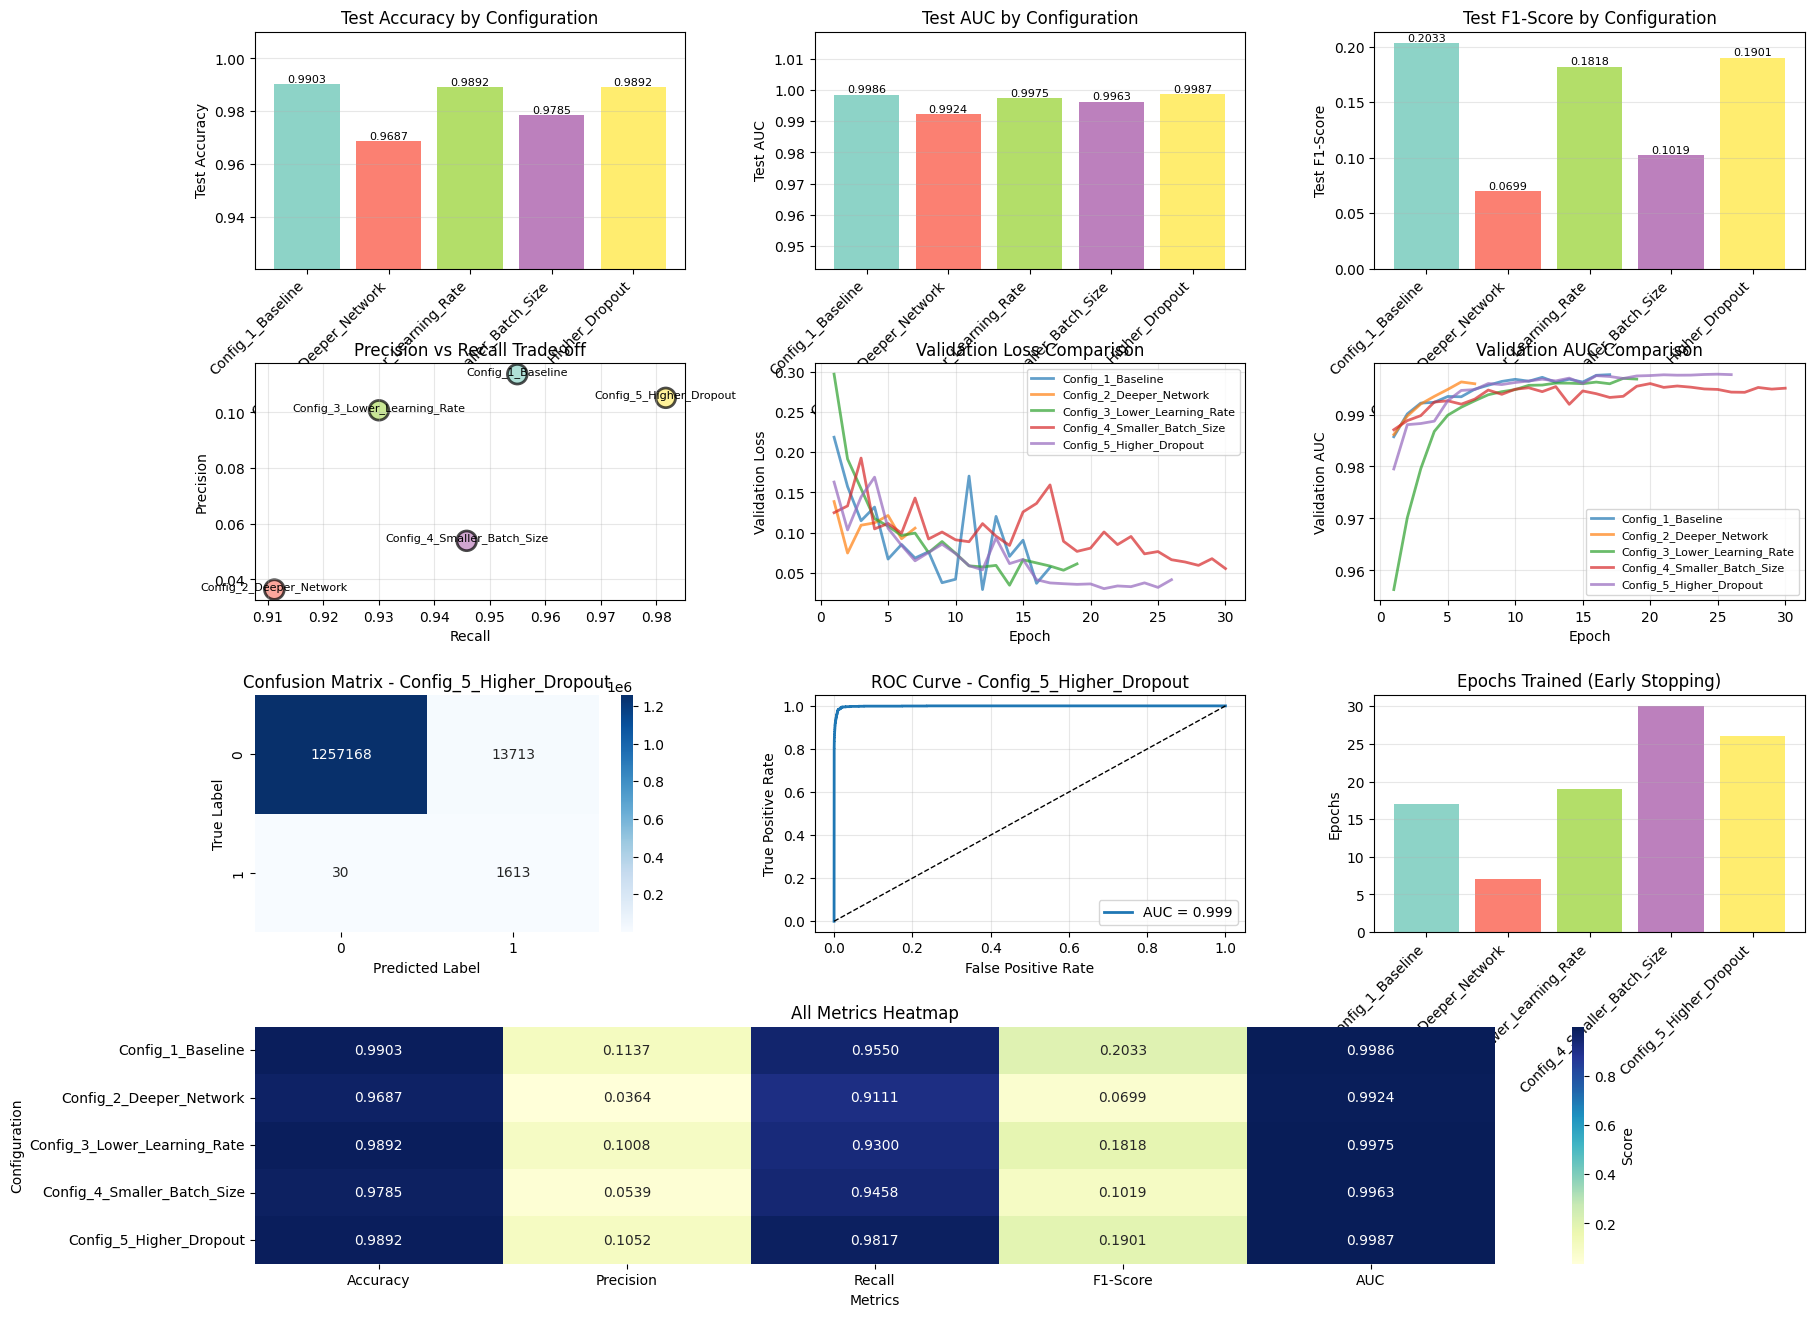

In [8]:
print("\n" + "="*80)
print("STEP 5: GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

config_names = [r['config_name'].replace('Config ', 'C') for r in results]
colors = plt.cm.Set3(np.linspace(0, 1, len(results)))

# 1. Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
test_accs = [r['test_accuracy'] for r in results]
bars = ax1.bar(range(len(config_names)), test_accs, color=colors)
ax1.set_xticks(range(len(config_names)))
ax1.set_xticklabels(config_names, rotation=45, ha='right')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy by Configuration')
ax1.set_ylim([min(test_accs)*0.95, max(test_accs)*1.02])
ax1.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 2. Test AUC Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_aucs = [r['test_auc'] for r in results]
bars = ax2.bar(range(len(config_names)), test_aucs, color=colors)
ax2.set_xticks(range(len(config_names)))
ax2.set_xticklabels(config_names, rotation=45, ha='right')
ax2.set_ylabel('Test AUC')
ax2.set_title('Test AUC by Configuration')
ax2.set_ylim([min(test_aucs)*0.95, max(test_aucs)*1.02])
ax2.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 3. Test F1-Score Comparison
ax3 = fig.add_subplot(gs[0, 2])
test_f1s = [r['test_f1'] for r in results]
bars = ax3.bar(range(len(config_names)), test_f1s, color=colors)
ax3.set_xticks(range(len(config_names)))
ax3.set_xticklabels(config_names, rotation=45, ha='right')
ax3.set_ylabel('Test F1-Score')
ax3.set_title('Test F1-Score by Configuration')
ax3.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 4. Precision vs Recall
ax4 = fig.add_subplot(gs[1, 0])
precisions = [r['test_precision'] for r in results]
recalls = [r['test_recall'] for r in results]
ax4.scatter(recalls, precisions, s=200, c=range(len(results)), cmap='Set3', 
           edgecolors='black', linewidth=2, alpha=0.7)
for i, name in enumerate(config_names):
    ax4.annotate(name, (recalls[i], precisions[i]), fontsize=8, ha='center')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Recall Trade-off')
ax4.grid(True, alpha=0.3)

# 5. Training History - Best Model Loss
ax5 = fig.add_subplot(gs[1, 1])
for i, result in enumerate(results):
    epochs = range(1, len(result['history']['loss']) + 1)
    ax5.plot(epochs, result['history']['val_loss'], label=config_names[i], 
            linewidth=2, alpha=0.7)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Validation Loss')
ax5.set_title('Validation Loss Comparison')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Training History - Best Model AUC
ax6 = fig.add_subplot(gs[1, 2])
for i, result in enumerate(results):
    epochs = range(1, len(result['history']['val_auc']) + 1)
    ax6.plot(epochs, result['history']['val_auc'], label=config_names[i], 
            linewidth=2, alpha=0.7)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Validation AUC')
ax6.set_title('Validation AUC Comparison')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Confusion Matrix - Best Model
ax7 = fig.add_subplot(gs[2, 0])
cm_best = np.array(best_config['confusion_matrix'])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=ax7)
ax7.set_title(f'Confusion Matrix - {best_config["config_name"]}')
ax7.set_ylabel('True Label')
ax7.set_xlabel('Predicted Label')

# 8. ROC Curve - Best Model
ax8 = fig.add_subplot(gs[2, 1])
fpr, tpr, _ = roc_curve(y_test, best_config['y_pred_proba'])
ax8.plot(fpr, tpr, linewidth=2, label=f'AUC = {best_config["test_auc"]:.3f}')
ax8.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax8.set_xlabel('False Positive Rate')
ax8.set_ylabel('True Positive Rate')
ax8.set_title(f'ROC Curve - {best_config["config_name"]}')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Epochs Trained Comparison
ax9 = fig.add_subplot(gs[2, 2])
epochs_trained = [r['epochs_trained'] for r in results]
bars = ax9.bar(range(len(config_names)), epochs_trained, color=colors)
ax9.set_xticks(range(len(config_names)))
ax9.set_xticklabels(config_names, rotation=45, ha='right')
ax9.set_ylabel('Epochs')
ax9.set_title('Epochs Trained (Early Stopping)')
ax9.grid(True, alpha=0.3, axis='y')

# 10. Metrics Heatmap
ax10 = fig.add_subplot(gs[3, :])
metrics_data = []
for result in results:
    metrics_data.append([
        result['test_accuracy'],
        result['test_precision'],
        result['test_recall'],
        result['test_f1'],
        result['test_auc']
    ])
metrics_df = pd.DataFrame(
    metrics_data,
    columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    index=config_names
)
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax10, 
           cbar_kws={'label': 'Score'})
ax10.set_title('All Metrics Heatmap')
ax10.set_xlabel('Metrics')
ax10.set_ylabel('Configuration')

plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'hyperparameter_tuning_results.png'")
plt.show()

In [9]:
print("\n" + "="*80)
print("STEP 6: SAVING DETAILED RESULTS")
print("="*80)

# Save results as JSON (without numpy arrays)
results_to_save = []
for result in results:
    result_copy = result.copy()
    result_copy.pop('y_pred_proba')  # Remove prediction array
    results_to_save.append(result_copy)

with open('hyperparameter_tuning_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print("✅ Detailed results saved to 'hyperparameter_tuning_results.json'")

# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved to 'scaler.pkl'")

print("\n" + "="*80)
print("🎉 HYPERPARAMETER TUNING COMPLETE!")
print("="*80)
print(f"\nBest Configuration: {best_config['config_name']}")
print(f"Best Test AUC: {best_config['test_auc']:.4f}")
print(f"Best Test F1: {best_config['test_f1']:.4f}")
print(f"\nAll results saved in:")
print("  - hyperparameter_comparison.csv")
print("  - hyperparameter_tuning_results.json")
print("  - hyperparameter_tuning_results.png")
print("  - Individual model files (.keras)")


STEP 6: SAVING DETAILED RESULTS
✅ Detailed results saved to 'hyperparameter_tuning_results.json'
✅ Scaler saved to 'scaler.pkl'

🎉 HYPERPARAMETER TUNING COMPLETE!

Best Configuration: Config_5_Higher_Dropout
Best Test AUC: 0.9987
Best Test F1: 0.1901

All results saved in:
  - hyperparameter_comparison.csv
  - hyperparameter_tuning_results.json
  - hyperparameter_tuning_results.png
  - Individual model files (.keras)
